In [6]:
import pandas as pd
import numpy as np
import wave
import os
import shutil
import subprocess
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import rfft, rfftfreq
from pathlib import Path
import librosa

# About this notebook
This notebook serves as a scratch pad for sketching out how the process the UrbanSound8K dataset
It is not well structured, can not be executed from top to bottom, etc.

All actual processing of the data is performed using the us8kdata package, the us8kdata-convert script, and the hasp package

In [2]:
## extract relevant metadata and copy it to data folder
metadata_df = pd.read_csv('../us8kdata/data/metadata/UrbanSound8K.csv')

In [3]:
metadata_df['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [83]:
metadata_df.head()

,slice_file_name,salience,fold,classID,class
0,100032-3-0-0.wav,1,5,3,dog_bark
1,100263-2-0-117.wav,1,5,2,children_playing
2,100263-2-0-121.wav,1,5,2,children_playing
3,100263-2-0-126.wav,1,5,2,children_playing
4,100263-2-0-137.wav,1,5,2,children_playing


In [4]:
from IPython.display import Audio

In [62]:
len(metadata_df)

8732

In [5]:
def path_builder(fname, fold):
    return Path(f'../us8kdata/data/fold{fold}/{fname}')

In [12]:
metadata_df.iloc[row_nr]

slice_file_name    100648-1-1-0.wav
salience                          2
fold                             10
classID                           1
class                      car_horn
Name: 10, dtype: object

In [29]:
row_nr = 0
display(metadata_df.iloc[row_nr])
Audio(path_builder(metadata_df.iloc[row_nr].iloc[0],metadata_df.iloc[row_nr].fold)) 

slice_file_name    100032-3-0-0.wav
salience                          1
fold                              5
classID                           3
class                      dog_bark
Name: 0, dtype: object

In [7]:
metadata_df.iloc[:,-2:].drop_duplicates()

,classID,class
0,3,dog_bark
1,2,children_playing
9,1,car_horn
22,0,air_conditioner
94,9,street_music
106,6,gun_shot
114,8,siren
122,5,engine_idling
171,7,jackhammer
196,4,drilling


In [7]:
lwav, lsr = librosa.load(path_builder(*metadata_df.iloc[0,[0,-3]]), sr=16000)

In [19]:
tsr, twav = wavfile.read(path_builder(*metadata_df.iloc[0,[0,-3]]))

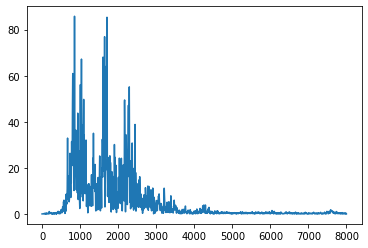

In [9]:
ty = rfft(lwav)
tx = rfftfreq(lwav.shape[0], 1/lsr)

plt.plot(tx, np.abs(ty))

array([-0.00466919, -0.00473022, -0.00491333, ..., -0.00317383,
       -0.0020752 , -0.00048828], dtype=float32)

(array([  5.,  18.,  81., 363., 717., 423., 266., 318., 263.,  87.]),
 array([ 4.94285315,  5.9335142 ,  6.92417526,  7.91483631,  8.90549737,
         9.89615842, 10.88681948, 11.87748054, 12.86814159, 13.85880265,
        14.8494637 ]),
 <BarContainer object of 10 artists>)

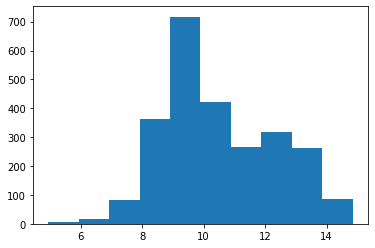

In [38]:
plt.hist(np.log(np.abs(ty)))

In [11]:
tsr2, twav2 = wavfile.read(path_builder(*metadata_df.iloc[2,[0,-3]]))

In [12]:
ty2 = rfft(twav2)
tx2 = rfftfreq(twav2.shape[0], 1/tsr2)

(array([  10.,  100.,  763., 3885., 6565., 6018., 9554., 4356.,  683.,
          67.]),
 array([ 19.00028405,  28.65984283,  38.31940161,  47.97896038,
         57.63851916,  67.29807793,  76.95763671,  86.61719549,
         96.27675426, 105.93631304, 115.59587182]),
 <BarContainer object of 10 artists>)

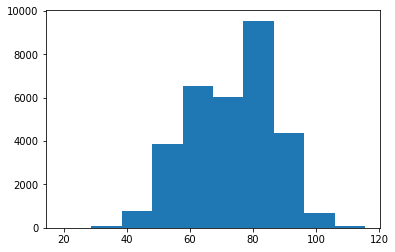

In [13]:
plt.hist(20 * np.log10(np.abs(ty2)))

In [14]:
twav2

array([-115,  -78,  -41, ...,   -6,  -49,  -64], dtype=int16)

In [17]:
def get_class_std_length_spectrums(classID):
    spectrums = []
    max_len = 0 # 4s
    for idx, row in metadata_df.query('classID == @classID').iterrows():
        tmp_sr, tmp_wav = wavfile.read(path_builder(row[0], row[-3]))
        if (wav_len := tmp_wav.shape[0]) > max_len:
            max_len = wav_len
    for idx, row in metadata_df.query('classID == @classID').iterrows():
        tmp_sr, tmp_wav = wavfile.read(path_builder(row[0], row[-3]))
        spectrums.append(rfft(np.pad(tmp_wav, (max_len - tmp_wav.shape[0],0))))
    
    spectrums = np.array(spectrums)
    return max_len, tmp_sr, spectrums
                                      


In [18]:
def plot_class_mean_spectrum(classID, ax=None, hpf=None, lpf=None):
    class_name = metadata_df.query('classID == @classID').iloc[0]['class']
    max_len, sr, spectrums = get_class_std_length_spectrums(classID)
    pow_spec = np.abs(spectrums)
    #pow_spec = pow_spec / pow_spec.max(axis=0)
    #pow_std = pow_spec.std(axis=0)
    pow_mean = pow_spec.mean(axis=0)
    #plt.plot(rfftfreq(max_len, 1/sr), pow_mean + pow_std, )
    freq_bins = rfftfreq(max_len, 1/sr)
    hpf if hpf else freq_bins.min()
    lpf = lpf if lpf else freq_bins.max()
    filter_mask = (freq_bins > hpf) & (freq_bins < lpf)
    if ax is None:
        plt.plot(freq_bins[filter_mask], pow_mean[filter_mask])
        plt.title(class_name)
    else:
        ax.plot(freq_bins[filter_mask], pow_mean[filter_mask])
        ax.set_title(class_name)
    #plt.plot(rfftfreq(max_len, 1/sr), pow_mean - pow_std)

In [96]:
max_len
#set(map(len, spectrums))
spectrums.shape

(429, 32001)

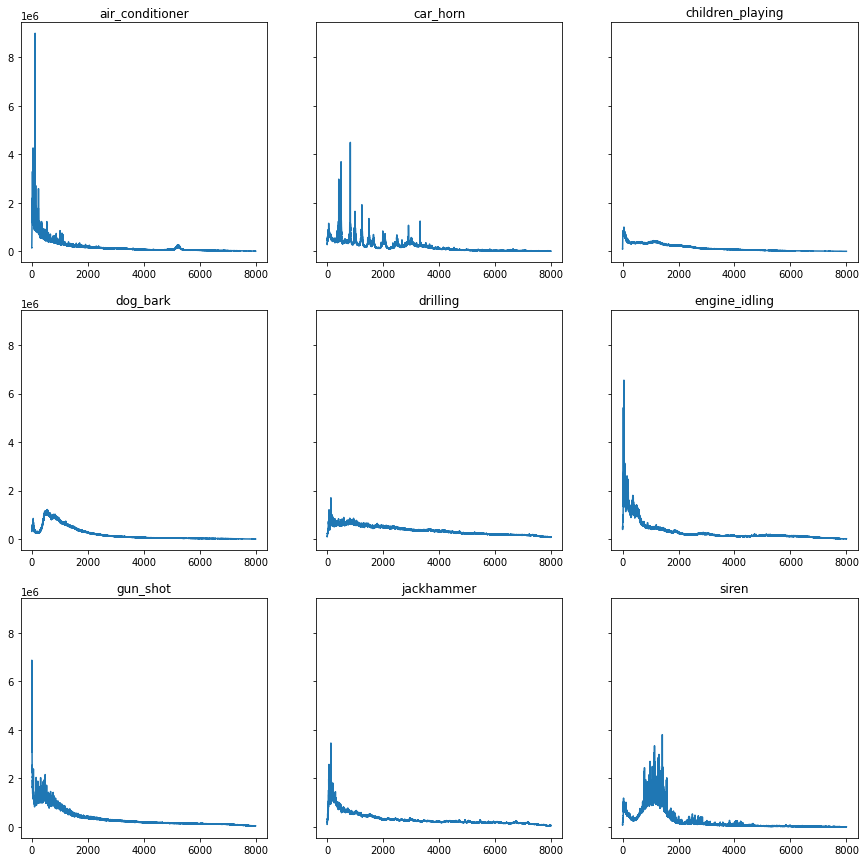

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(15,15), sharey=True)
for classID, ax in zip(range(10), axes.flat):
    plot_class_mean_spectrum(classID, ax, hpf=0, lpf=8000)


In [22]:
sr, samples = wavfile.read('../us8kdata/data/fold1/101415-3-0-3.wav')

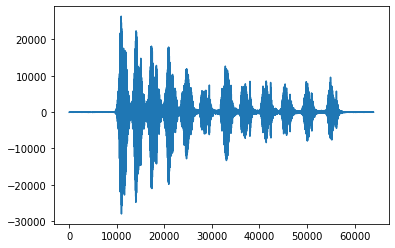

In [23]:
plt.plot(samples)

In [20]:
Audio('../us8kdata/data/fold1/101415-3-0-3.wav')

In [24]:
tfft = rfft(samples)

In [25]:
tfreqs = rfftfreq(len(samples), 1/sr)

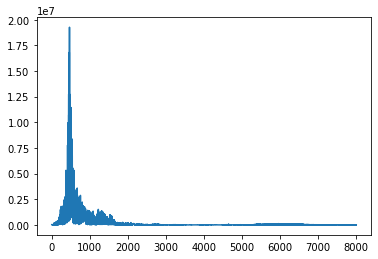

In [26]:
plt.plot(tfreqs, np.abs(tfft))

In [28]:
tfft.shape, tfreqs.shape, samples.shape

((32001,), (32001,), (64000,))

In [47]:
path2 = path_builder(metadata_df.iloc[row_nr].iloc[0],metadata_df.iloc[row_nr].fold)
sr2, samples2 = wavfile.read(path2)

In [32]:
tfft2 = rfft(samples2)

In [33]:
tfreqs2 = rfftfreq(len(samples2), 1/sr2)

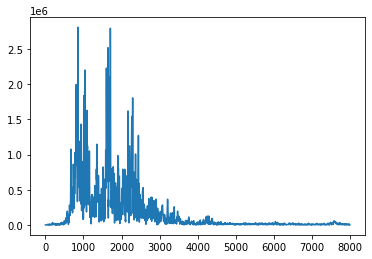

In [34]:
plt.plot(tfreqs2, np.abs(tfft2))

In [48]:
tfft2.shape, tfreqs2.shape, samples2.shape

((2541,), (2541,), (5081,))

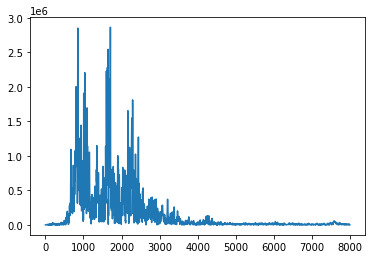

In [49]:
samples2_pad = np.pad(samples2, (0, 64000 - samples2.shape[0]))
tfft2_pad = rfft(samples2_pad)
tfreqs2_pad = rfftfreq(len(samples2_pad), 1/sr2)
plt.plot(tfreqs2_pad, np.abs(tfft2_pad))

In [50]:
tfft2_pad.shape, tfreqs2_pad.shape, samples2_pad.shape

((32001,), (32001,), (64000,))

In [54]:
np.abs(tfft2_pad), tfreqs2_pad

(array([ 319.        ,  327.10440424,  350.57830798, ..., 1410.27818597,
        1416.84684504, 1419.        ]),
 array([0.00000e+00, 2.50000e-01, 5.00000e-01, ..., 7.99950e+03,
        7.99975e+03, 8.00000e+03]))

MFCC Mel Frequency Cepstrum Coefficient

In [58]:
band_pass_filter = ((tfreqs2_pad > 500) & (tfreqs2_pad < 3500))

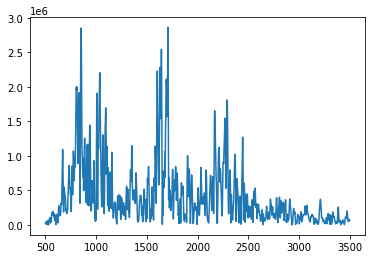

In [59]:
plt.plot(tfreqs2_pad[band_pass_filter], np.abs(tfft2_pad[band_pass_filter]))

In [60]:
tfft2_pad[band_pass_filter].shape

(11999,)

In [69]:
import librosa.display

(1025, 10)

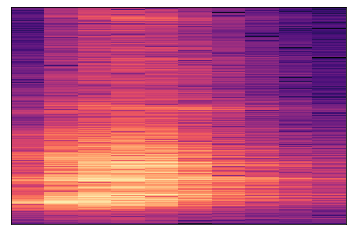

In [107]:

lftt = librosa.stft(samples2.astype(np.float32))
display(lftt.shape)
librosa.display.specshow(librosa.power_to_db(np.abs(lftt)), sr=sr2)

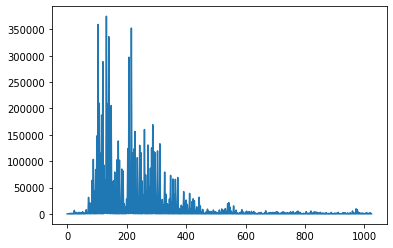

In [108]:
plt.plot(np.abs(lftt.mean(axis=1)))

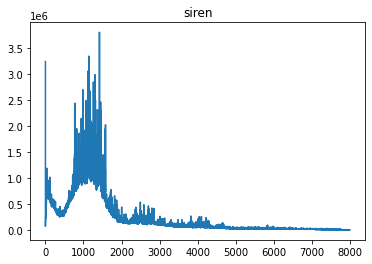

In [15]:
plot_class_mean_spectrum(8)

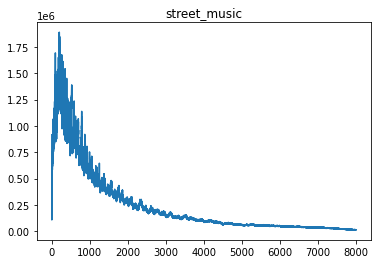

In [16]:
plot_class_mean_spectrum(9)

In [25]:
def get_fold_mfcc_mean_vectors(folds, sr=16000):
    spectrums = []
    for idx, row in metadata_df.query('fold in @folds').iterrows():
        #tmp_wav, tmp_sr = librosa.load(path_builder(row[0], row[-3]), sr=sr)
        tmp_sr, tmp_wav = wavfile.read(path_builder(row[0], row[-3]))
        tmp_wav = tmp_wav.astype(np.float32) / np.iinfo(np.int16).max
        #spectrum = librosa.stft(tmp_wav.astype(np.float), n_fft=1024)
        #pow_spectrum = np.abs(spectrum)
        mfcc = librosa.feature.mfcc(y=tmp_wav, sr=tmp_sr)
        spectrums.append(mfcc.mean(axis=1))
    
    spectrums = np.array(spectrums)
    return tmp_sr, spectrums

In [17]:
metadata_df[['classID', 'class']].drop_duplicates()

,classID,class
0,3,dog_bark
1,2,children_playing
9,1,car_horn
22,0,air_conditioner
94,9,street_music
106,6,gun_shot
114,8,siren
122,5,engine_idling
171,7,jackhammer
196,4,drilling


In [26]:
%%time
fsr, fold1_spectrums = get_fold_mfcc_mean_vectors([1,3,4,5,6,7,8,9])

/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1550
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1757
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1917
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1696
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1600
  r

CPU times: user 2min 57s, sys: 37.2 s, total: 3min 34s
Wall time: 30.6 s


In [27]:
fold1_three_class_y = ( metadata_df.query('fold in [1,3,4,5,6,7,8,9]').classID 
                       * metadata_df.query('fold in [1,3,4,5,6,7,8,9]').classID.isin([1,8]))

In [65]:
fold1_three_class_y.value_counts()

0    5898
8     755
1     354
Name: classID, dtype: int64

In [30]:
fsr, fold2_spectrums = get_fold_mfcc_mean_vectors([2])

/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1600
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=960
  return f(*args, **kwargs)


In [31]:
from sklearn.linear_model import LogisticRegression

In [35]:
car_siren_idx = metadata_df.query('fold == 2').classID.isin([1,8]).values

In [36]:
from sklearn.metrics import recall_score, precision_score

In [66]:
model = LogisticRegression(max_iter=1000)


In [76]:
model.fit(fold1_spectrums, 
         metadata_df.query('fold in [1,3,4,5,6,7,8,9]').classID, 
        #fold1_three_class_y,
         )

/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [77]:
model.score(fold2_spectrums,#[car_siren_idx], 
            metadata_df.query('fold == 2').classID.values)#[car_siren_idx])

0.42342342342342343

In [134]:
metadata_df.query('fold == 2').classID.iloc[:10]

14     3
15     3
16     3
17     3
103    3
153    5
154    5
155    8
156    8
157    8
Name: classID, dtype: int64

In [78]:
recall_score(model.predict(fold2_spectrums[car_siren_idx]), 
             metadata_df.query('fold == 2').classID.values[car_siren_idx],
             average='weighted')

0.5413533834586466

In [79]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(
confusion_matrix(model.predict(fold2_spectrums[car_siren_idx]), 
             metadata_df.query('fold == 2').classID.values[car_siren_idx], labels=[0,1,2,4,5,6,7,8,9])
, index=[0,1,2,4,5,6,7,8,9], columns=[0,1,2,4,5,6,7,8,9])

,0,1,2,4,5,6,7,8,9
0,0,2,0,0,0,0,0,2,0
1,0,11,0,0,0,0,0,0,0
2,0,22,0,0,0,0,0,7,0
4,0,2,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,4,0
6,0,2,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,61,0
9,0,0,0,0,0,0,0,0,0


In [63]:
metadata_df.query('fold == 2').classID.values[car_siren_idx]

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8,
       1])

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
model_rfc = RandomForestClassifier()

In [41]:
%%time
model_rfc.fit(fold1_spectrums, fold1_three_class_y, )

CPU times: user 1.73 s, sys: 12.8 ms, total: 1.74 s
Wall time: 1.74 s


RandomForestClassifier()

In [42]:
model_rfc.score(fold2_spectrums[car_siren_idx], metadata_df.query('fold == 2').classID.values[car_siren_idx])

0.41353383458646614

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
model_knc = KNeighborsClassifier()

In [45]:
%%time
model_knc.fit(fold1_spectrums, fold1_three_class_y, )

CPU times: user 2.7 ms, sys: 5.94 ms, total: 8.64 ms
Wall time: 14.1 ms


KNeighborsClassifier()

In [46]:
model_knc.score(fold2_spectrums[car_siren_idx], metadata_df.query('fold == 2').classID.values[car_siren_idx])

/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.2706766917293233